In [1]:
import numpy as np
import os
import pandas as pd
import time
import math
import re
from itertools import groupby
from operator import itemgetter
# package for io 
from aicsimageio.writers import OmeTiffWriter
from aicsimageio.readers import tiff_reader, OmeTiffReader
from aicsimageio.readers.czi_reader import CziReader

import itertools
import skimage
from skimage import measure as skmeasure
import datetime
from CustomFunctions import shparam_mod, metadata_funcs
from CustomFunctions.file_management import multicsv
from scipy.spatial import distance
from scipy import interpolate
from CustomFunctions.persistance_activity import get_pa, DA_3D
from CustomFunctions import segment_LLS


# load in some stuff to speed up processing
# (following https://sedeh.github.io/python-pandas-multiprocessing-workaround.html)
import multiprocessing

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)
    

def mygrouper(n, iterable):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))
    


def get_intensity_features(img, seg):
    features = {}
    input_seg = seg.copy()
    input_seg = (input_seg>0).astype(np.uint8)
    input_seg_lcc = skmeasure.label(input_seg)
    for mask, suffix in zip([input_seg, input_seg_lcc], ['', '_lcc']):
        values = img[mask>0].flatten()
        if values.size:
            features[f'intensity_mean{suffix}'] = values.mean()
            features[f'intensity_std{suffix}'] = values.std()
            features[f'intensity_1pct{suffix}'] = np.percentile(values, 1)
            features[f'intensity_99pct{suffix}'] = np.percentile(values, 99)
            features[f'intensity_max{suffix}'] = values.max()
            features[f'intensity_min{suffix}'] = values.min()
        else:
            features[f'intensity_mean{suffix}'] = np.nan
            features[f'intensity_std{suffix}'] = np.nan
            features[f'intensity_1pct{suffix}'] = np.nan
            features[f'intensity_99pct{suffix}'] = np.nan
            features[f'intensity_max{suffix}'] = np.nan
            features[f'intensity_min{suffix}'] = np.nan
    return features



def dist_f(a1, b1, c1, a2, b2, c2):

    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

# Function to find Angle
def angle_distance(a1, b1, c1, a2, b2, c2):
    a1,b1,c1 = [a1,b1,c1]/np.linalg.norm([a1,b1,c1])
    a2,b2,c2 = [a2,b2,c2]/np.linalg.norm([a2,b2,c2])
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

In [13]:
###### Get the trajectory info from all of the position info

#define directory stuff
dirr = 'E:/Aaron/random_lls/'
savedir = 'E:/Aaron/random_lls_smooth/Data_and_Figs/'
datadir = dirr + 'processed_data/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

time_interval = 5
    
#combine all of the cell csvs into one dataframe
fileslist = [x for x in os.listdir(datadir) if x.endswith('.csv')]
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=60)
    csvlist = [datadir+i for i in fileslist]
    celllist = pool.map(multicsv, csvlist)
    pool.close()
    pool.join()
cellinfo = pd.concat(celllist).reset_index(drop=True)
cellinfo['CellID'] = [re.split(r'(-\d+-Subset)',x)[0]+ '_'+ re.findall(r'Subset-(\d+)', x)[0] for x in cellinfo.cell.to_list()]

dflist = []
for i, df in cellinfo.groupby('CellID'):

    #first get dataframe in time order
    df = df.sort_values(by = 'time').reset_index(drop=True)


    #make sure there are no gaps due to failed segmentations
    if any(abs(df.frame.diff())>1):
        diff = df.time.diff()
        difflist = [0]
        difflist.extend(diff[diff>5].index.to_list())
        runs = []
        for x in range(len(difflist)-1):
            runs.append(list(range(difflist[x], difflist[x+1])))
    else:
        runs = [df.index.to_list()]

    #save the df in case it gets broken up later    
    brokendf = df.copy()

    for r in runs:
        if len(r)>2:
            df = brokendf.iloc[r].reset_index(drop=True)
            #set the k order for interpolation to the max possible
            if len(df)<6:
                kay = len(df)-1
            else:
                kay = 5

            #rename the raw pos data so it's used correctly
            df = df.drop(columns = ['x','y','z'])
            df.rename(columns={"x_raw": "x", "y_raw": "y", "z_raw": "z"}, inplace = True)

            #do speed and trajectory stuff
            pos = df[['x','y','z']]
            if bool(pos[pos.duplicated()].index.tolist()):
                ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                # if there is duplicate positions
                dups = pos[pos.duplicated()].index.tolist()
                pos_drop = pos.drop(dups, axis = 0)
                if pos_drop.shape[0]<3:
                    traj = np.zeros([1,len(pos),3])
                    trajsmo = pos.to_numpy().copy()
                else:
                    #get trajectories without the duplicates
                    tck, u = interpolate.splprep(pos_drop.to_numpy().T, k=kay, s=120)
                    yderv = interpolate.splev(u,tck,der=1)
                    traj = np.vstack(yderv).T
                    #get smoothened trajectory
                    ysmo = interpolate.splev(u,tck,der=0)
                    trajsmo = np.vstack(ysmo).T
                    #re-insert duplicate row that was dropped
                    for d, dd in enumerate(dups):
                        traj = np.insert(traj, dd, traj[dd-1,:], axis=0)
                        trajsmo = np.insert(trajsmo, dd, trajsmo[dd-1,:], axis=0)

            else:
                ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                #no duplicate positions
                #interpolate and get tangent at midpoint
                tck, b = interpolate.splprep(pos.to_numpy().T, k=kay, s=120)
                yderv = interpolate.splev(b,tck,der=1)
                traj = np.vstack(yderv).T
                #get smoothened trajectory
                ysmo = interpolate.splev(b,tck,der=0)
                trajsmo = np.vstack(ysmo).T

            ###add smoothened trajectory positions 
            #change x y z names in the dataframe
            df.rename(columns={"x": "x_raw", "y": "y_raw", "z": "z_raw"}, inplace = True)
            #add smoothened positions
            df['x'] = trajsmo[:,0]
            df['y'] = trajsmo[:,1]
            df['z'] = trajsmo[:,2]

            ############## Bayesian persistence and activity #################
            persistence, activity, speed = get_pa(df, time_interval)
            df['persistence'] = np.concatenate([np.array([np.nan]*2), persistence])
            df['activity'] = np.concatenate([np.array([np.nan]*2), activity])
            df['speed'] = np.concatenate([np.array([np.nan]), speed])
            df['avg_persistence'] = np.array([persistence.mean()]*(len(persistence)+2))
            df['avg_activity'] = np.array([activity.mean()]*(len(activity)+2))
            df['avg_speed'] = np.array([speed.mean()]*(len(speed)+1))

            #add directional autocorrelations
            df['directional_autocorrelation'] = DA_3D(df[['x','y','z']].to_numpy())

            #get the trajectory and the previous trajectory for each frame and 
            #save as an individual dataframe for each cell and frame
            for v, row in df.iterrows():
                if v==0:
                    row['Prev_Trajectory_X'] = np.nan
                    row['Prev_Trajectory_Y'] = np.nan
                    row['Prev_Trajectory_Z'] = np.nan
                    row['Trajectory_X'] = traj[v,0]
                    row['Trajectory_Y'] = traj[v,1]
                    row['Trajectory_Z'] = traj[v,2]
                    row['Turn_Angle'] = np.nan
                    dflist.append(row)

                if v>0:
                    row['Prev_Trajectory_X'] = traj[v-1,0]
                    row['Prev_Trajectory_Y'] = traj[v-1,1]
                    row['Prev_Trajectory_Z'] = traj[v-1,2]
                    row['Trajectory_X'] = traj[v,0]
                    row['Trajectory_Y'] = traj[v,1]
                    row['Trajectory_Z'] = traj[v,2]
                    if all(traj[v-1,:] == traj[v,:]):
                        row['Turn_Angle'] = 0
                    else:
                        row['Turn_Angle'] = angle_distance(traj[v-1,0], traj[v-1,1], traj[v-1,2], traj[v,0], traj[v,1], traj[v,2])
                    dflist.append(row)

    print(f'Finished tracking cell {i}')
pd.DataFrame(dflist).to_csv(savedir+'trajectory_info.csv')

Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_01
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_02
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_03
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_04
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_05
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_06
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_07
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_08
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_09
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_01
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_02
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_03
Finished tracking cell 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_04

Finished tracking cell 20240625_488_EGFP-CAAX_640_actin-halotag_10uMCK666_cell3_01
Finished tracking cell 20240625_488_EGFP-CAAX_640_actin-halotag_10uMCK666_cell3_02
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell1_01
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell2_01
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell2_02
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell2_03
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell2_04
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell2_05
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell2_06
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell3_01
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell3_02
Finished tracking cell 20240626_488_EGFP-CAAX_561_mysoin-mApple_01perDMSO_cell3_03
Fini

Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell2_01
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell2_02
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell2_03
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell2_04
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell3_01
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell4_01
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell4_02
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell5_01
Finished tracking cell 20240708_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell5_02
Finished tracking cell 20240708_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell1_01
Finished tracking cell 202407

Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell1_03
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell1_04
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell2_01
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell2_02
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell3_01
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell3_02
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell3_03
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell3_04
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell3_05
Finished tracking cell 20240711_488_EGFP-CAAX_561_mysoin-mApple_10uMParaNitroBlebbistatin_cell3_06
Finished t

In [4]:
############## find the width rotation angles through time

dirr = 'E:/Aaron/random_lls/'
imdir = dirr + 'processed_images/'
savedir = 'E:/Aaron/random_lls_smooth/Data_and_Figs/'
if not os.path.exists(savedir):
    os.makedirs(savedir)


xyres = 0.145 #um / pixel 
zstep = 0.145 # um
align_method = 'trajectory'
sigma = 0
allresults = []

trajinfo = pd.read_csv(savedir+'trajectory_info.csv', index_col = 0)

for i, cell in trajinfo.groupby('CellID'):
    cell = cell.reset_index(drop=True)
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for j, c in cell.iterrows():
            #get path to segmented image
            impath = imdir + c.cell + '_segmented.tiff'
            csvdir = c.to_dict()
            #put in the pool
            pool.apply_async(shparam_mod.find_normal_width_peaks, args = (
                impath,
                csvdir,
                xyres,
                zstep,
                sigma,
                align_method,
                ),             
                callback = collect_results)
        pool.close()
        pool.join()
        #sort the results based on the movie order and frame order
        results.sort(key=lambda x: (float(re.findall(r'(\d+)-Subset', x[0])[0]), float(re.findall('(?<=frame_)\d*', x[0])[0])))
        #put results into an ordered dataframe
        tempframe = pd.DataFrame(results, columns = ['cell','Width_Peaks'])
        tempframe['frame'] = [float(re.findall('(?<=frame_)\d*', x[0])[0]) for x in results]
    
        runs = list()
        #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
        for k, g in groupby(enumerate(tempframe['frame']), lambda ix: ix[0] - ix[1]):
            currentrun = list(map(itemgetter(1), g))
            list.append(runs, currentrun)


        #find the minima in each frame that are closest to the minimum chosen in the last frame
        #aka the one that results in the least amount of consecutive rotation
        fullminlist = []
        runcount = 0
        for xx in runs:
            runframe = tempframe.iloc[runcount:int(runcount+len(xx))]
            #add to runcount
            runcount = runcount + len(xx)
            wplist = runframe.Width_Peaks.to_list()
            seeds = []
            allallmins = []
            #for all the starting peaks find the least different rotations through time
            for s in wplist[0]:
                allmins = [s]
                for wp in wplist[1:]:
                    if bool(len(wp) == 0):
                        allmins.append(allmins[-1])
                    else:
                        allmins.append(wp[np.argmin(abs(wp-(allmins[-1])))])
                allallmins.append(allmins)
                seeds.append(np.sum(abs(np.diff(allmins))))
            #add rotations of current run to the list
            fullminlist.extend(allallmins[np.argmin(seeds)])


        #add all mins to tempframe
        tempframe['Closest_minimums'] = fullminlist

        allresults.append(tempframe)

        print(f'Finished {i}')

#save the shape metrics dataframe
bigdf = pd.concat(allresults)
bigdf.to_csv(savedir + 'Closest_Width_Peaks.csv')


Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_01
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_02
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_03
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_04
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_05
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_06
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_07
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_08
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_09
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_01
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_02
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_03
Finished 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_04
Finished 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell1_01
Finished 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell1_02
Finished 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_c

Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell2_01
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell2_02
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell3_01
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell3_02
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell3_03
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_10uMCK666_cell1_01
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_10uMCK666_cell1_02
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_10uMCK666_cell2_01
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_10uMCK666_cell2_02
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_10uMCK666_cell2_03
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_10uMCK666_cell3_01
Finished 20240626_488_EGFP-CAAX_640_SPY650-DNA_10uMCK666_cell4_01
Finished 20240702_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell1_01
Finished 20240702_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell1_02
Finished 20240702_488_EGFP-CAAX_640_SPY650-DNA_01perDMSO_cell1_03
Finished 2

Finished 20240709_488_EGFP-CAAX_640_SPY650-DNA_10uMParaNitroBlebbistatin_cell4_02
Finished 20240709_488_EGFP-CAAX_640_SPY650-DNA_10uMParaNitroBlebbistatin_cell4_03
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell1_01
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell1_02
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell2_01
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell2_02
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell2_03
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell2_04
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell3_01
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell3_02
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell3_03
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell3_04
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell3_05
Finished 20240709_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell3_06
Finished

Finished 20240711_488_EGFP-CAAX_640_actin-halotag_10uMParaNitroBlebbistatin_cell4_07
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_01
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_02
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_03
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_04
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_05
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_06
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_07
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_08
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_01
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_02
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_03
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_04
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_05
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_06
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_07
Finished 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_08
Finished 20240805_4

In [22]:
datadir = mindir+'processed_data/'
if not os.path.exists(datadir):
    os.makedirs(datadir)
for i, row in trajinfo.iterrows():
    pd.DataFrame(row).T.reset_index(drop=True).to_csv(datadir+row.cell+'_cell_info.csv')

In [3]:
############## GET SURFACE MESHES AND OTHER SHAPE STATS ##############

mindir = 'E:/Aaron/random_lls_smooth/'
savedir = mindir + 'processed_images/'
#make dirs if it doesn't exist
datadir = mindir + 'Data_and_Figs/'
meshf = mindir+'Meshes/'  
if not os.path.exists(meshf):
    os.makedirs(meshf)
pilrf = mindir+'PILRs/'
if not os.path.exists(pilrf):
    os.makedirs(pilrf)

    

xyres = 0.145 #um / pixel 
zstep = 0.145 # um
align_method = 'trajectory'
norm_rot = 'provided'
l_order = 10
nisos = [1,63]
pilr_method = ''
sigma = 0
errorlist = []


if norm_rot == 'provided':
    widthpeaks = pd.read_csv(datadir + 'Closest_Width_Peaks.csv', index_col = 0)
    
#get all segmented images that were analyzed
trajinfo = pd.read_csv(datadir+'trajectory_info.csv', index_col = 0)
#get list of frames and cells that were actually fully analyzed
datalist = trajinfo.cell.to_list()
imlist = [x for x in os.listdir(savedir) if x.endswith('segmented.tiff') and x.split('_segmented.tiff')[0] in datalist]


start = 0
stop = 1000
allresults = []
while start<len(imlist):
    print(f'Finished {start}, starting {start}-{stop}')
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for i in imlist[start:stop]:
            
            #choose structure name based on file name
            if 'actin' in i:
                str_name = 'actin'
            elif ('Hoechst' in i) or ('DNA' in i):
                str_name = 'nucleus'
            elif 'myosin' in i:
                str_name = 'myosin'
            else:
                str_name = ''
            
            #assign the normal rotation value for that particular cell
            if (norm_rot == 'provided') or (type(norm_rot) == float):
#                 try:
                norm_rot = float(widthpeaks[widthpeaks.cell == i.split('_segment')[0]]['Closest_minimums'].values[0])
#                 #exception for if 
#                 except:
#                     norm_rot = 'widest weighted'
                    
            #put in the pool
            pool.apply_async(shparam_mod.shcoeffs_and_PILR_nonuc, args = (
                i,
                mindir,
                xyres,
                zstep,
                str_name,
                errorlist,
                norm_rot,
                l_order,
                nisos,
                pilr_method,
                sigma,
                align_method,
                ),             
                callback = collect_results)

        pool.close()
        pool.join()
    
    allresults.extend(results)
    
    start = stop + 1
    stop = stop + 1000
    if stop>len(imlist):
        stop = len(imlist)

errorlist = []
bigdf = pd.DataFrame()

for r in allresults:
    

    Shape_Stats = pd.DataFrame([r[0].values()],
                                  columns = list(r[0].keys()))
    cell_coeffs = pd.DataFrame([r[1].values()],
                               columns = list(r[1].keys()))

    bigdf = bigdf.append(pd.concat([Shape_Stats,cell_coeffs], axis=1))

    errorlist.extend(r[2])


#save the shape metrics dataframe
bigdf = bigdf.set_index('cell')
bigdf.to_csv(datadir + 'Shape_Metrics.csv')

#save list of cells that don't have centroid in shape
pd.Series(errorlist).to_csv(datadir + 'ListToExclude.csv')

Finished 0, starting 0-1000
Finished 1001, starting 1001-2000
Finished 2001, starting 2001-3000
Finished 3001, starting 3001-4000
Finished 4001, starting 4001-5000
Finished 5001, starting 5001-6000
Finished 6001, starting 6001-7000
Finished 7001, starting 7001-8000
Finished 8001, starting 8001-9000
Finished 9001, starting 9001-10000
Finished 10001, starting 10001-11000
Finished 11001, starting 11001-12000
Finished 12001, starting 12001-13000
Finished 13001, starting 13001-14000
Finished 14001, starting 14001-15000
Finished 15001, starting 15001-16000
Finished 16001, starting 16001-17000
Finished 17001, starting 17001-18000
Finished 18001, starting 18001-19000
Finished 19001, starting 19001-20000
Finished 20001, starting 20001-21000
Finished 21001, starting 21001-22000
Finished 22001, starting 22001-23000
Finished 23001, starting 23001-24000
Finished 24001, starting 24001-25000
Finished 25001, starting 25001-26000
Finished 26001, starting 26001-26466


In [4]:
import numpy as np
import pandas as pd
import os
import re
#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools
from CustomFunctions.file_management import multicsv
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools
import pickle as pk
import multiprocessing

In [5]:
############# gather data from all experiments ###############
folders = ['random_lls_smooth']
smlst = []
atilst = []
for f in folders:
    tempfl = f'E:/Aaron/{f}/'
    sm = pd.read_csv(tempfl + 'Data_and_Figs/Shape_Metrics.csv', index_col = 0)
    
    excludes = pd.read_csv(tempfl + 'Data_and_Figs/ListToExclude.csv', index_col=0)
    exlist = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
    sm = sm.loc[[x for x in sm.index if x not in exlist]]

    #add all of the other metrics from the single csv files
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes=60)
        csvlist = [tempfl + 'processed_data/' + i +'_cell_info.csv' for i in sm.index.to_list()]
        celllist = pool.map(multicsv, csvlist)
        pool.close()
        pool.join()
    cellinfo = pd.concat(celllist)

    smlst.append(sm)
    atilst.append(cellinfo)
    
### make dataframes and merge    
smdf = pd.concat(smlst)
atidf = pd.concat(atilst)
df = smdf.merge(atidf.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')


In [6]:
########### FILTER THE DATA A BIT ###############
print(len(df))

############# filter out shape outliers #############
df = df[df.Cell_Volume > 458]
df = df[df.Cell_SurfaceArea < 1700]
print(len(df))

############## filter out speed outliers #############
### these seem to come from segmentation failures that move the cell centroid
df = df[df.speed < 1.3]
# df = df.drop(df[df.isin(df[df.speed>1.3].CellID.unique()).any(axis=1)].index).reset_index(drop=True)
print(len(df))

############# filter out 20240528 ##############
df = df[~df.cell.str.contains('20240528', na=False)].reset_index(drop=True)
print(len(df))

25359
25280
24456
21848


In [7]:
######### Perform PCA and divide cells into shape space bins ################


savedir = 'E:/Aaron/random_lls_smooth/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10


#get coeffs only
coeff_df = df[[x for x in df.columns.to_list() if 'shcoeffs' in x]]


# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = df.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1

df_trans = df_trans.drop(columns = 'Cell_Volume')



################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})

    
mid = math.ceil(nbins/2)
recon_PCs = np.zeros((npcs, nbins, npcs))
for pi, p in enumerate(pc_names):
    for c in range(nbins):
        for ni, n in enumerate(pc_names):
            if n == p:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
            else:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

#get inverse pca transform of those values
recon_schoeffs = np.zeros((npcs, nbins, len(coeff_df.columns)))
for o in range(recon_schoeffs.shape[0]):
    for t in range(recon_schoeffs.shape[1]):
            recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])
            
    
#combine metrics and digitized pcs
df_dig = df.merge(df_dig, left_index = True, right_index = True)
#save the digitized PCs for the shape space
df_dig.to_csv(savedir+"Shape_Metrics_with_Digitized_PCs.csv")
#save just the PCs with the other cell data, no digitized PCs
digless = df_dig.drop(columns=[x for x in df_dig.columns.to_list() if 'shcoeff' in x or 'bin' in x or '.1' in x]).reset_index(drop=True)
digless.to_csv(savedir+"Shape_Metrics_with_PCs.csv")

########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

meshes = {}
aliases = ['Cell']

for pi, p in enumerate(pc_names):
    meshes[p] = {}
    for c in range(nbins):
        meshes[p][bins[c]] = {}
        row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
        for i, a in enumerate(aliases):
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]][a] = mesh

                
                
################## save PC meshes ##################
pcmeshdir = savedir + 'PC_Meshes/'
if not os.path.exists(pcmeshdir):
    os.makedirs(pcmeshdir)
for p in list(meshes):
    for n, b in enumerate(list(meshes[p])):
        for a in list(meshes[p][b]):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(pcmeshdir+p+'_'+str(b)+'_'+a+'.vtp')
            writer.SetInputData(meshes[p][b][a])
            writer.Write()

####### also save the pca object for later use ###########
pk.dump(pca, open(savedir+"pca.pkl","wb"))



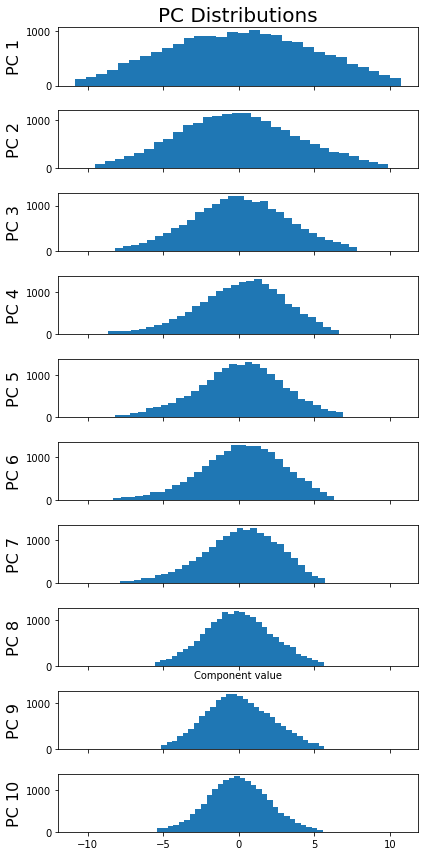

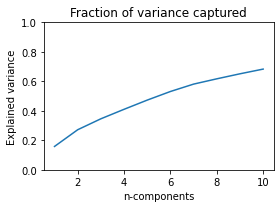

In [8]:
##################### PCA relevant figures #######################


########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(digless[pc_names].iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(savedir+ 'PC distributions.png', bbox_inches='tight')



# How much variance is explained?
cell_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Analysis of explained variance
df_dimred = {}
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
for comp, pc_name in enumerate(pc_names):
    load = loading[:, comp]
    pc = [v for v in load]
    apc = [v for v in np.abs(load)]
    total = np.sum(apc)
    cpc = [100 * v / total for v in apc]
    df_dimred[pc_name] = pc
    df_dimred[pc_name.replace("_PC", "_aPC")] = apc
    df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

# Store results as a dataframe
df_dimred["features"] = coeff_df.columns
df_dimred = pd.DataFrame(df_dimred)
df_dimred = df_dimred.set_index("features", drop=True)

# Plot variance
plt.figure(figsize=(4, 3))
plt.plot(component_number, cell_variance)
plt.ylim(0,1)
plt.xlabel("n-components")
plt.ylabel("Explained variance")
plt.title("Fraction of variance captured")

plt.tight_layout()
plt.savefig(savedir + 'Variance captured.png', bbox_inches='tight')



# ######## OR A DIFFERENT PLOT ##############
# # Make plot of explained variance
# plt.plot(100 * pca.explained_variance_ratio_[:npcs_to_calc], "-o")
# title = "Cum. variance: (1+2) = {0}%, Total = {1}%".format(
#     int(100 * pca.explained_variance_ratio_[:2].sum()),
#     int(100 * pca.explained_variance_ratio_[:].sum()),
# )
# plt.xlabel("Component", fontsize=18)
# plt.ylabel("Explained variance (%)", fontsize=18)
# plt.xticks(
#     ticks=np.arange(npcs_to_calc),
#     labels=np.arange(1, 1 + npcs_to_calc),
#     fontsize=14,
# )
# plt.yticks(fontsize=14)
# plt.title(title, fontsize=18)
# plt.tight_layout()



############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
save = savedir + 'Feature_Importance'
# Log feature importance along each PC
with open(f"{save}.txt", "w") as flog:

    for comp in range(npcs):

        print(
            f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
            file=flog,
        )

        # Feature importance is reported in 3 ways:
        # _PC - raw loading
        # _aPC - absolute loading
        # _cPC - normalized cummulative loading
        pc_name = pc_names[comp]
        df_sorted = df_dimred.sort_values(
            by=[pc_name.replace("_PC", "_aPC")], ascending=False
        )
        pca_cum_contrib = np.cumsum(
            df_sorted[pc_name.replace("_PC", "_aPC")].values
            / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
        )
        pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
        df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

        print(
            df_sorted[
                [
                    pc_name,
                    pc_name.replace("_PC", "_aPC"),
                    pc_name.replace("_PC", "_cPC"),
                ]
            ].head(),
            file=flog,
        )

In [9]:
############# CALCULATE A BUNCH OF METRICS ###################
from scipy.spatial import ConvexHull
#get directories and open separated datasets
from itertools import groupby
from operator import itemgetter
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A


savedir = 'E:/Aaron/random_lls_smooth/'
    
    
nbins = 11


#get directories
TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_with_PCs.csv', index_col = 0)

#remove the "Cell_" from PCs
for x in TotalFrame.columns.to_list():
    if 'PC' in x:
        TotalFrame = TotalFrame.rename(columns = {x:x.replace('Cell_','')})
#add a column that identifies cells across all frames
TotalFrame['CellID'] = [re.split(r'(-\d+-Subset)',x)[0]+ '_'+ re.findall(r'Subset-(\d+)', x)[0] for x in TotalFrame.cell.to_list()]

#Add Elongation metric
TotalFrame['Cell_Elongation'] = TotalFrame['Cell_MajorAxis']/TotalFrame['Cell_MinorAxis']

#Add Volume Ratios
TotalFrame['Volume_Front_Ratio'] = TotalFrame.Cell_Volume_Front/TotalFrame.Cell_Volume
TotalFrame['Volume_Right_Ratio'] = TotalFrame.Cell_Volume_Right/TotalFrame.Cell_Volume
TotalFrame['Volume_Top_Ratio'] = TotalFrame.Cell_Volume_Top/TotalFrame.Cell_Volume


#sphericity calculation (ratio of surface area of circle with same volume to actual surface area)
Cell_Sphere = []
for index, row in TotalFrame.iterrows():
    #cell sphericity
    r = ((3*row.Cell_Volume)/(4*math.pi)) ** (1/3)
    SA = 4*math.pi*r
    Cell_Sphere.append(SA/row.Cell_SurfaceArea)
TotalFrame['Cell_Sphericity'] = Cell_Sphere


######### Get angles of long axes relative to the axis of trajectory #############
RelativeAngles = pd.DataFrame()
vectors = sorted([i for i in row.index if 'MajorAxis_Vec' in i])
# row = RandomRotations.iloc[0]
for index, row in TotalFrame.iterrows():
    angles = {}
    arr = row[vectors].to_numpy()
    if arr[0] < 0:
        arr = arr*-1
    #get angle between the vector and the planes
    UpDownAngle = distance(arr[0], arr[1], arr[2], arr[0], arr[1], 0)
    LeftRightAngle = distance(arr[0], arr[1], arr[2], arr[0], 0, arr[2])
    TotalAngle = distance(arr[0], arr[1], arr[2], 1, 0, 0)
    #append angles
    rx = vectors[0].split('_')[0]
    angles[rx +'_UpDownAngle'] = UpDownAngle if arr[2]>0 else -1*UpDownAngle
    angles[rx +'_LeftRightAngle'] = LeftRightAngle if arr[1]>0 else -1*LeftRightAngle
    angles[rx +'_TotalAngle'] = TotalAngle
    RelativeAngles = RelativeAngles.append(angles, ignore_index=True)
#add the angles to the dataframe and remove vectors
TotalFrame = TotalFrame.merge(RelativeAngles, left_index = True, right_index = True)


pclist = [x for x in TotalFrame.columns.to_list() if 'PC' in x]
centers = []
for count, col in enumerate(pclist):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = TotalFrame,
        feature = col,
        nbins = nbins,
        filter_based_on = pclist,
        filter_extremes_pct = 0,
        save = None,
        return_freqs_per_structs = False,
    )
    #put bin_indexes into a larger list that I can later iterate through
    TotalFrame[f'PC{count+1}bins'] = df_digit.bin
    #get bin centers for each PC
    centers.append(pd.Series(bin_centers*pc_std, name=col))
centers = pd.DataFrame(centers).T
centers.to_csv(savedir+'PC_bin_centers.csv')


################ add all of the different classifiers to the dataset
treat = []
experiment = []
date = []

for f, m in zip(TotalFrame['cell'].to_list(), TotalFrame['frame'].to_list()):
    if 'CK666' in f:
        treat.append('CK666')
        experiment.append('Drug')
    elif 'ParaNitroBleb' in f:
        treat.append('Para-Nitro-Blebbistatin')
        experiment.append('Drug')
    elif 'DMSO' in f:
        treat.append('DMSO')
        experiment.append('Drug')
    else:
        treat.append('Random')
        experiment.append('Random')

            
    #get the date and experiment number on that date
    spl = f.split('_')
    date.append(spl[0])

TotalFrame['Date'] = date
TotalFrame['Treatment'] = treat
TotalFrame['Experiment'] = experiment
            
            
# ############ calculate the distance travelled between time points in the PC1-PC2 CGPS ##########
# to = []
# fromm = []
# idd = []
# ae = []
# for i, cells in TotalFrame.sort_values('frame').groupby('CellID'):
#     runs = list()
#     #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
#     for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
#         currentrun = list(map(itemgetter(1), g))
#         list.append(runs, currentrun)

#     for r in runs:
#         r = np.array(r, dtype=int)
#         cell = cells[cells.frame.isin(r)]
#         tdiffs = cell[['PC1bins','PC2bins']].diff()
#         fdiffs = cell[['PC1bins','PC2bins']].diff(-1)
#         PC1_PC2_distance_to = []
#         PC1_PC2_distance_from = []
#         points = []
#         area_explored = []
#         for d in range(len(cell)):
#             #calculate the change distance the cell HAS travelled
#             PC1_PC2_distance_to.append(np.sqrt(tdiffs.iloc[d].PC1bins**2 + tdiffs.iloc[d].PC2bins**2))
#             #calculate the change distance the cell WILL travel
#             PC1_PC2_distance_from.append(np.sqrt(fdiffs.iloc[d].PC1bins**2 + fdiffs.iloc[d].PC2bins**2))
#             #points explored
#             points.append(cell.iloc[d][['PC1bins','PC2bins']].to_list())
#             #calculate convex hull at this time point
#             try:
#                 area_explored.append(ConvexHull(points).area)
#             except:
#                 area_explored.append(0)
#         to.extend(PC1_PC2_distance_to)
#         fromm.extend(PC1_PC2_distance_from)
#         idd.extend(cell.cell.to_list())
#         ae.extend(area_explored)
# #add them to the the total dataframe
# TotalFrame = TotalFrame.merge(pd.DataFrame({'cell':idd,
#               'PC1_PC2_distance_to':to,
#               'PC1_PC2_distance_from':fromm,
#                 'PC1_PC2_cumulative_area_explored':ae}),
#               left_on = ['cell'],
#             right_on = ['cell'])

TotalFrame.to_csv(savedir + 'Shape_Metrics_transitionPCbins.csv')
print('Calculated combined PCs and binned PCs')

Calculated combined PCs and binned PCs


In [10]:
#find the length of cell consecutive frames
results = []
for i, cells in TotalFrame.groupby('CellID'):
    cells = cells.sort_values('time').reset_index(drop = True)
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)
    maxrun = max([len(l) for l in runs])
    sumrun = sum([len(l) for l in runs])
    actualrun = max(runs, key=len, default=[])
    results.append([i, maxrun, actualrun, sumrun])
#find
stdf = pd.DataFrame(results, columns = ['CellID','length_of_run','actual_run','total_runs']).sort_values('total_runs', ascending=False).reset_index(drop=True)
#get cells with more than 30 minutes of continuous footage
longcells = stdf[stdf.total_runs>360].CellID.to_list()
TotalFrame = TotalFrame[TotalFrame.CellID.isin(longcells)].copy()
stdf

,CellID,length_of_run,actual_run,total_runs
0,20240611_488_EGFP-CAAX_640_actin-halotag_cell7_01,51,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...",537
1,20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_c...,53,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...",536
2,20240524_488_EGFP-CAAX_640_actin-halotag_cell2_01,53,"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5...",517
3,20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01,42,"[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...",502
4,20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1_01,27,"[98, 99, 100, 101, 102, 103, 104, 105, 106, 10...",477
...,...,...,...,...
366,20240711_488_EGFP-CAAX_640_actin-halotag_01per...,2,"[1, 2]",2
367,20240708_488_EGFP-CAAX_640_SPY650-DNA_01perDMS...,2,"[8, 9]",2
368,20240711_488_EGFP-CAAX_640_actin-halotag_01per...,1,[4],1
369,20240702_488_EGFP-CAAX_640_actin-halotag_01per...,1,[9],1


685.0021939143455


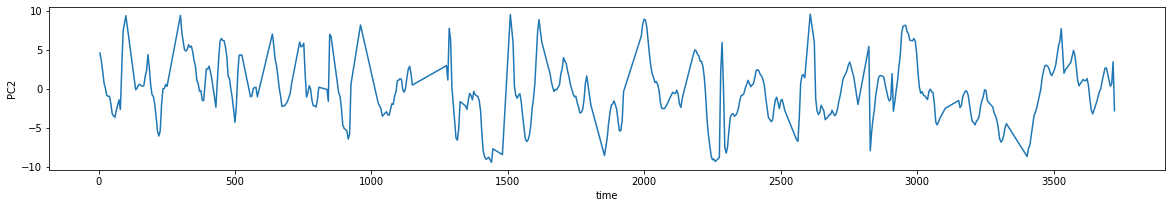

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
cell = TotalFrame[TotalFrame.CellID == TotalFrame.CellID.unique()[0]].sort_values('time').reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20,3))
sns.lineplot(data=cell, x='time',y='PC2', ax = ax)
print(abs(cell.PC2.diff()).sum())
plt.savefig('C:/Users/Aaron/Desktop/'+cell.CellID.iloc[0]+'PC2 random only s120 smoothened.png')